In [65]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from prettytable import PrettyTable
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.pytorch

plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('lines', markersize=10)

In [66]:
df = pd.read_csv('enriched/de_train_enriched.csv')
final_predictions = pd.read_csv('enriched/final_prediction.csv')

In [67]:
df.head()

,cell_type,sm_name,sm_lincs_id,SMILES,control,count_mean_x,count_sum_x,normalized_count_mean_x,normalized_count_sum_x,donor_id,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,2.569838,1113646.0,6.089993,2594365.5,donor_0,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,2.569838,1113646.0,6.089993,2594365.5,donor_1,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,2.569838,1113646.0,6.089993,2594365.5,donor_2,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,3.512137,3467640.0,5.708712,5590162.0,donor_0,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,3.512137,3467640.0,5.708712,5590162.0,donor_1,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


In [68]:
df.columns

Index(['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control',
       'count_mean_x', 'count_sum_x', 'normalized_count_mean_x',
       'normalized_count_sum_x', 'donor_id',
       ...
       'ZUP1', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', length=18238)

In [69]:
final_predictions.head()

,cell_type,sm_name,MolecularWeight_x,XLogP3-AA_x,HydrogenBondDonorCount_x,HydrogenBondAcceptorCount_x,RotatableBondCount_x,ExactMass_x,MonoisotopicMass_x,TopologicalPolarSurfaceArea_x,...,HydrogenBondAcceptorCount_y,RotatableBondCount_y,ExactMass_y,MonoisotopicMass_y,TopologicalPolarSurfaceArea_y,HeavyAtomCount_y,FormalCharge_y,Complexity_y,IsotopeAtomCount_y,CovalentlyBondedUnitCount_y
0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...,354.4,0.8,1,8,3,354.191657,354.191657,108.0,...,8,3,354.191657,354.191657,108.0,26,0,466.0,0,1
1,B cells,ABT-199,868.4,8.2,3,11,12,867.318096,867.318096,183.0,...,11,12,867.318096,867.318096,183.0,61,0,1640.0,0,1
2,B cells,ABT737,813.4,9.0,2,10,15,812.258139,812.258139,165.0,...,10,15,812.258139,812.258139,165.0,56,0,1320.0,0,1
3,B cells,AMD-070,349.5,2.4,2,4,7,349.226646,349.226646,70.8,...,4,7,349.226646,349.226646,70.8,26,0,431.0,0,1
4,B cells,AT 7867,337.8,4.3,2,2,3,337.134575,337.134575,40.7,...,2,3,337.134575,337.134575,40.7,24,0,394.0,0,1


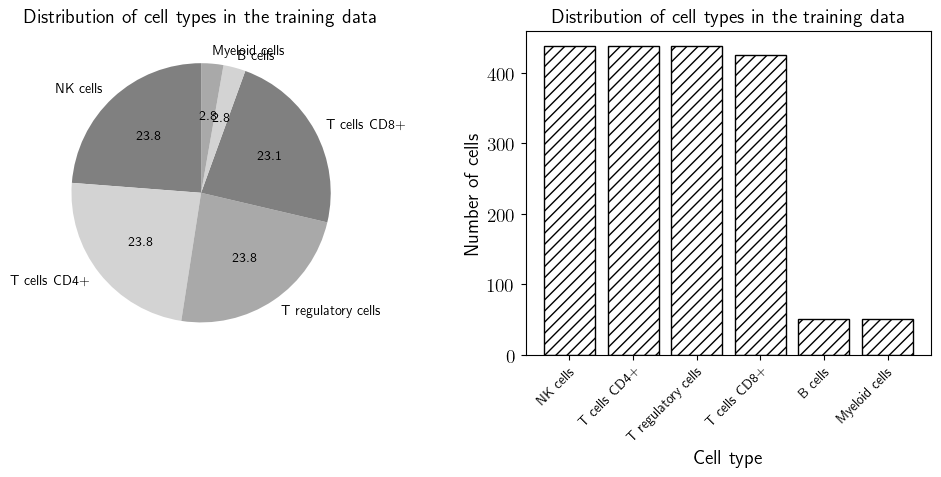

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pie(df["cell_type"].value_counts(), labels=df["cell_type"].value_counts().index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10}, colors=["grey", "lightgrey", "darkgrey"])
ax[0].set_title("Distribution of cell types in the training data")
ax[1].bar(df["cell_type"].value_counts().index, df["cell_type"].value_counts(), edgecolor="black", facecolor="white", hatch="///")
ax[1].set_xlabel("Cell type")
ax[1].set_ylabel("Number of cells")
ax[1].set_title("Distribution of cell types in the training data")
plt.xticks(rotation=45, ha="right", rotation_mode="anchor", fontsize=10)
plt.tight_layout()
plt.show()

In [71]:
# X variables are: cell_type,sm_name,sm_lincs_id,SMILES,control,count_mean_x,count_sum_x,normalized_count_mean_x,normalized_count_sum_x,donor_id,count_mean_y,count_sum_y,normalized_count_mean_y,normalized_count_sum_y,MolecularWeight,XLogP3-AA,HydrogenBondDonorCount,HydrogenBondAcceptorCount,RotatableBondCount,ExactMass,MonoisotopicMass,TopologicalPolarSurfaceArea,HeavyAtomCount,FormalCharge,Complexity,IsotopeAtomCount,CovalentlyBondedUnitCount

X = df[['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control', 'count_mean_x', 'count_sum_x',
        'normalized_count_mean_x', 'normalized_count_sum_x', 'donor_id', 'count_mean_y', 'count_sum_y',
        'normalized_count_mean_y', 'normalized_count_sum_y', 'MolecularWeight', 'XLogP3-AA', 'HydrogenBondDonorCount',
        'HydrogenBondAcceptorCount', 'RotatableBondCount', 'ExactMass', 'MonoisotopicMass',
        'TopologicalPolarSurfaceArea', 'HeavyAtomCount', 'FormalCharge', 'Complexity', 'IsotopeAtomCount',
        'CovalentlyBondedUnitCount']]
y = df.drop(X.columns, axis=1)

In [72]:
X.head()

,cell_type,sm_name,sm_lincs_id,SMILES,control,count_mean_x,count_sum_x,normalized_count_mean_x,normalized_count_sum_x,donor_id,...,HydrogenBondAcceptorCount,RotatableBondCount,ExactMass,MonoisotopicMass,TopologicalPolarSurfaceArea,HeavyAtomCount,FormalCharge,Complexity,IsotopeAtomCount,CovalentlyBondedUnitCount
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,2.569838,1113646.0,6.089993,2594365.5,donor_0,...,1,4,344.108026,344.108026,17.8,25,0,396.0,0,1
1,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,2.569838,1113646.0,6.089993,2594365.5,donor_1,...,1,4,344.108026,344.108026,17.8,25,0,396.0,0,1
2,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,2.569838,1113646.0,6.089993,2594365.5,donor_2,...,1,4,344.108026,344.108026,17.8,25,0,396.0,0,1
3,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,3.512137,3467640.0,5.708712,5590162.0,donor_0,...,1,4,344.108026,344.108026,17.8,25,0,396.0,0,1
4,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,3.512137,3467640.0,5.708712,5590162.0,donor_1,...,1,4,344.108026,344.108026,17.8,25,0,396.0,0,1


In [73]:
print("The features shape is: ", X.shape)
print("The target shape is: ", y.shape)

The features shape is:  (1842, 27)
The target shape is:  (1842, 18211)


In [74]:
cell_types = df['cell_type'].values

In [75]:
print("The unique cell types are: ", set(cell_types))

The unique cell types are:  {'B cells', 'Myeloid cells', 'T cells CD4+', 'NK cells', 'T cells CD8+', 'T regulatory cells'}


In [76]:
indices_t_nk = np.where((cell_types == 'T cells CD4+') | (cell_types == 'NK cells') | (cell_types == 'T cells CD8+') | (cell_types == 'T regulatory cells'))[0]
indices_b_myeloid = np.where((cell_types == 'B cells') | (cell_types == 'Myeloid cells'))[0]

In [77]:
# Use 10% of B and Myeloid cells for training
n_train_b_myeloid = int(0.1 * len(indices_b_myeloid))
indices_train_b_myeloid = np.random.choice(indices_b_myeloid, size=n_train_b_myeloid, replace=False)
indices_test_b_myeloid = np.setdiff1d(indices_b_myeloid, indices_train_b_myeloid)

In [78]:
# We take 10% of B and Myeloid cells for training + all T cells, NK cells and T regulatory cells
train_indices = np.concatenate((indices_train_b_myeloid, indices_t_nk))
test_indices = indices_test_b_myeloid

In [79]:
print("The number of training cells is: ", len(train_indices))
print("The number of test cells is: ", len(test_indices))

The number of training cells is:  1750
The number of test cells is:  92


In [80]:
# Drop SMILES, encoded all other categorical variables, using mappings
X = X.drop(['SMILES'], axis=1)
encoder = LabelEncoder()
X['cell_type'] = X['cell_type'].map({'B cells': 0, 'Myeloid cells': 1, 'NK cells': 2, 'T cells CD4+': 3, 'T cells CD8+': 4, 'T regulatory cells': 5})
X['sm_name'] = encoder.fit_transform(X['sm_name'])
X['sm_lincs_id'] = encoder.fit_transform(X['sm_lincs_id'])
X['control'] = encoder.fit_transform(X['control'])
X['donor_id'] = encoder.fit_transform(X['donor_id'])

In [81]:
X_train = X.iloc[train_indices]
y_train = y.iloc[train_indices]
X_test = X.iloc[test_indices]
y_test = y.iloc[test_indices]

In [82]:
table = PrettyTable()
table.field_names = ["", "Value"]
table.add_row(["Number of training samples", X_train.shape[0]])
table.add_row(["Number of test samples", X_test.shape[0]])
table.add_row(["Number of features", X_train.shape[1]])
table.add_row(["Number of classes", y_train.shape[1]])
print(table)

+----------------------------+-------+
|                            | Value |
+----------------------------+-------+
| Number of training samples |  1750 |
|   Number of test samples   |   92  |
|     Number of features     |   26  |
|     Number of classes      | 18211 |
+----------------------------+-------+


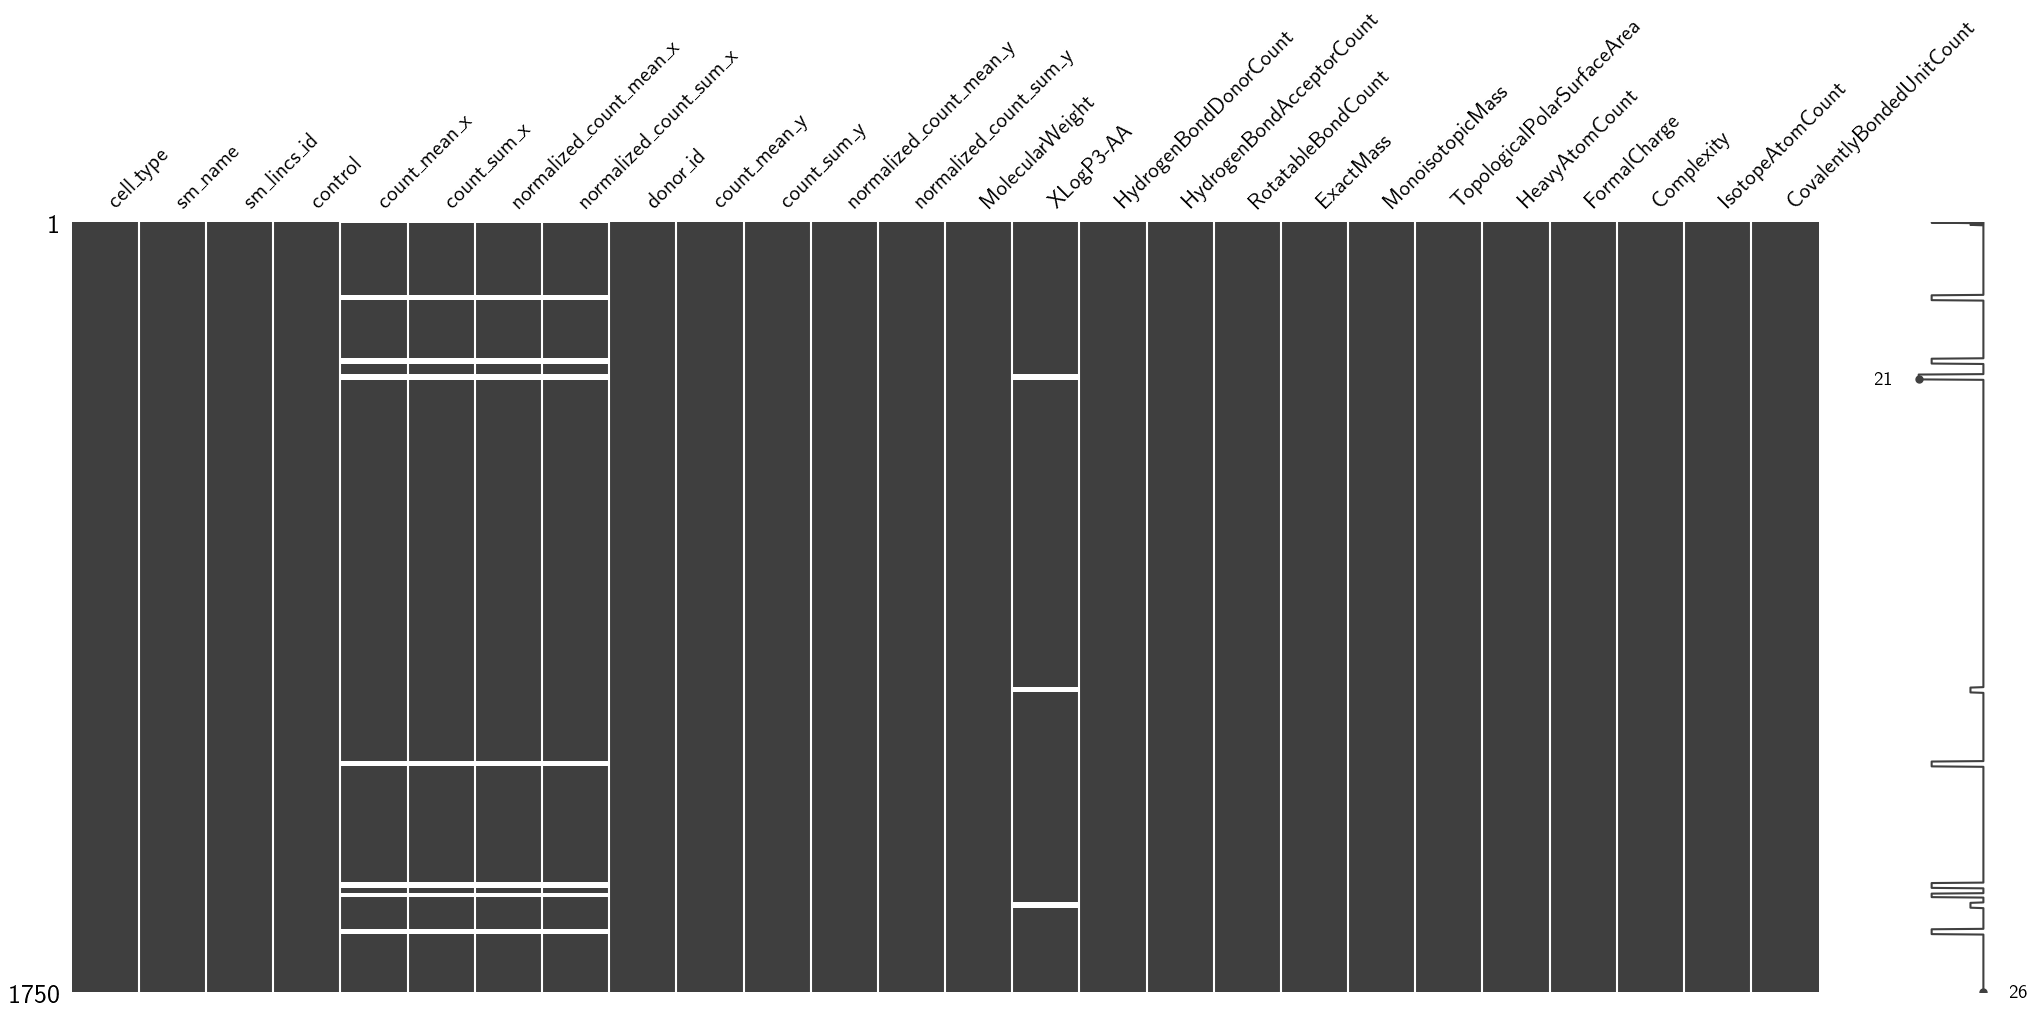

In [90]:
# Check for missing values
msno.matrix(X_train)
plt.show()

In [92]:
class BaseLearner(nn.Module):
        def __init__(self):
                super(BaseLearner, self).__init__()
                self.fc1 = nn.Linear(27, 256)
                self.fc2 = nn.Linear(256, 512)
                self.fc3 = nn.Linear(512, 18211)

        def forward(self, x):
                x = torch.relu(self.fc1(x))
                x = torch.relu(self.fc2(x))
                x = self.fc3(x)
                return x


# Meta Learner
class MetaLearner(nn.Module):
        def __init__(self):
                super(MetaLearner, self).__init__()
                self.fc1 = nn.Linear(512 + 1, 256)
                self.fc2 = nn.Linear(256, 18211)

        def forward(self, x):
                x = torch.relu(self.fc1(x))
                x = self.fc2(x)
                return x

In [95]:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)

In [96]:
base_learner = BaseLearner()
meta_learner = MetaLearner()

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(list(base_learner.parameters()) + list(meta_learner.parameters()), lr=0.001)

# Training Loop
for epoch in range(100):
        # Forward pass through base learner
        base_output = base_learner(X_train)
        cell_type = cell_types[train_indices]
        cell_type = torch.tensor(cell_type).unsqueeze(1)

        # Concatenate base learner output with cell type
        meta_input = torch.cat((base_output, cell_type), dim=1)

        # Forward pass through meta learner
        meta_output = meta_learner(meta_input)

        # Compute loss and backpropagate
        loss = criterion(meta_output, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Log metrics to MLflow
        mlflow.log_metric("epoch", epoch)
        mlflow.log_metric("loss", loss.item())

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float